In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import warnings 
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

#divisao treino e teste
from sklearn.model_selection import train_test_split

#modelos
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#metricas
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, plot_confusion_matrix 

#validacao
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")

df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


Criando novas colunas que serao utilizadas no machine learning (Rushing Mean e Passing Mean)

In [2]:
r_off_agg = df[(df.play_type == 'run')]
p_off_agg = df[(df.play_type == 'pass')|(df.play_type == 'sack')]

r_off_agg = r_off_agg.groupby(['game_id','qtr','posteam'])['yards_gained'].mean().reset_index()
p_off_agg = p_off_agg.groupby(['game_id','qtr','posteam'])['yards_gained'].mean().reset_index()

r_off_agg = r_off_agg.rename(columns={'yards_gained':'RushingMean'})
p_off_agg = p_off_agg.rename(columns={'yards_gained':'PassingMean'})

off_agg = pd.merge(r_off_agg, p_off_agg, left_on=['game_id','qtr','posteam'], right_on=['game_id','qtr','posteam'], how='outer')

off_agg.head()



,game_id,qtr,posteam,RushingMean,PassingMean
0,2009091000,1,PIT,0.333333,-0.125000
1,2009091000,1,TEN,6.166667,6.222222
2,2009091000,2,PIT,2.500000,9.062500
3,2009091000,2,TEN,1.400000,8.307692
4,2009091000,3,PIT,2.000000,3.000000


In [3]:
df = df.merge(off_agg)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436122 entries, 0 to 436121
Columns: 257 entries, play_id to PassingMean
dtypes: float64(137), int64(18), object(102)
memory usage: 858.5+ MB


Escolhendo as colunas que serao utilizadas no machine learning

In [5]:
df = df[["qtr", "yardline_100", "ydstogo", "half_seconds_remaining","down","score_differential","posteam","posteam_type","play_type","game_seconds_remaining","posteam_timeouts_remaining","PassingMean","RushingMean"]]
df.head()

,qtr,yardline_100,ydstogo,half_seconds_remaining,down,score_differential,posteam,posteam_type,play_type,game_seconds_remaining,posteam_timeouts_remaining,PassingMean,RushingMean
0,1,30.0,0,1800.0,NaN,NaN,PIT,home,kickoff,3600.0,3.0,-0.125,0.333333
1,1,58.0,10,1793.0,1.0,0.0,PIT,home,pass,3593.0,3.0,-0.125,0.333333
2,1,53.0,5,1756.0,2.0,0.0,PIT,home,run,3556.0,3.0,-0.125,0.333333
3,1,56.0,8,1715.0,3.0,0.0,PIT,home,pass,3515.0,3.0,-0.125,0.333333
4,1,56.0,8,1707.0,4.0,0.0,PIT,home,punt,3507.0,3.0,-0.125,0.333333


Apagando as linhas que contem informacoes em branco

In [6]:
df = df.dropna()
df.isnull().sum()

qtr                           0
yardline_100                  0
ydstogo                       0
half_seconds_remaining        0
down                          0
score_differential            0
posteam                       0
posteam_type                  0
play_type                     0
game_seconds_remaining        0
posteam_timeouts_remaining    0
PassingMean                   0
RushingMean                   0
dtype: int64

In [7]:
df.nunique()

qtr                              5
yardline_100                    99
ydstogo                         47
half_seconds_remaining        1801
down                             4
score_differential             109
posteam                         35
posteam_type                     2
play_type                        7
game_seconds_remaining        3601
posteam_timeouts_remaining       4
PassingMean                   1780
RushingMean                    877
dtype: int64

Apagando as linhas da coluna playtype que nao forem pass ou run

In [8]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'NaN'
    return categorical_map

In [9]:
country_map = shorten_categories(df.play_type.value_counts(), 100000)
df['play_type'] = df['play_type'].map(country_map)
df.play_type.value_counts()

pass    183949
run     131843
NaN      61650
Name: play_type, dtype: int64

In [10]:
df =  df[df.play_type != 'NaN']

In [11]:
df.nunique()

qtr                              5
yardline_100                    99
ydstogo                         46
half_seconds_remaining        1801
down                             4
score_differential             108
posteam                         35
posteam_type                     2
play_type                        2
game_seconds_remaining        3601
posteam_timeouts_remaining       4
PassingMean                   1780
RushingMean                    877
dtype: int64

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 315792 entries, 1 to 436121
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   qtr                         315792 non-null  int64  
 1   yardline_100                315792 non-null  float64
 2   ydstogo                     315792 non-null  int64  
 3   half_seconds_remaining      315792 non-null  float64
 4   down                        315792 non-null  float64
 5   score_differential          315792 non-null  float64
 6   posteam                     315792 non-null  object 
 7   posteam_type                315792 non-null  object 
 8   play_type                   315792 non-null  object 
 9   game_seconds_remaining      315792 non-null  float64
 10  posteam_timeouts_remaining  315792 non-null  float64
 11  PassingMean                 315792 non-null  float64
 12  RushingMean                 315792 non-null  float64
dtypes: float64(8),

In [13]:
df = df.dropna()
df.isnull().sum()

qtr                           0
yardline_100                  0
ydstogo                       0
half_seconds_remaining        0
down                          0
score_differential            0
posteam                       0
posteam_type                  0
play_type                     0
game_seconds_remaining        0
posteam_timeouts_remaining    0
PassingMean                   0
RushingMean                   0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315792 entries, 1 to 436121
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   qtr                         315792 non-null  int64  
 1   yardline_100                315792 non-null  float64
 2   ydstogo                     315792 non-null  int64  
 3   half_seconds_remaining      315792 non-null  float64
 4   down                        315792 non-null  float64
 5   score_differential          315792 non-null  float64
 6   posteam                     315792 non-null  object 
 7   posteam_type                315792 non-null  object 
 8   play_type                   315792 non-null  object 
 9   game_seconds_remaining      315792 non-null  float64
 10  posteam_timeouts_remaining  315792 non-null  float64
 11  PassingMean                 315792 non-null  float64
 12  RushingMean                 315792 non-null  float64
dtypes: float64(8),

In [15]:
df.head()

,qtr,yardline_100,ydstogo,half_seconds_remaining,down,score_differential,posteam,posteam_type,play_type,game_seconds_remaining,posteam_timeouts_remaining,PassingMean,RushingMean
1,1,58.0,10,1793.0,1.0,0.0,PIT,home,pass,3593.0,3.0,-0.125,0.333333
2,1,53.0,5,1756.0,2.0,0.0,PIT,home,run,3556.0,3.0,-0.125,0.333333
3,1,56.0,8,1715.0,3.0,0.0,PIT,home,pass,3515.0,3.0,-0.125,0.333333
5,1,43.0,10,1584.0,1.0,0.0,PIT,home,pass,3384.0,3.0,-0.125,0.333333
6,1,40.0,7,1548.0,2.0,0.0,PIT,home,pass,3348.0,3.0,-0.125,0.333333


Apagando 200.000 linhas porque estava tendo problemas ao fazer o machine learning devido ao tamanho.

In [16]:
n = 200000
df.drop(index=df.index[:n],inplace=True)

Transformando colunas que possuem informacoes no formato string em int

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115792 entries, 276133 to 436121
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   qtr                         115792 non-null  int64  
 1   yardline_100                115792 non-null  float64
 2   ydstogo                     115792 non-null  int64  
 3   half_seconds_remaining      115792 non-null  float64
 4   down                        115792 non-null  float64
 5   score_differential          115792 non-null  float64
 6   posteam                     115792 non-null  object 
 7   posteam_type                115792 non-null  object 
 8   play_type                   115792 non-null  object 
 9   game_seconds_remaining      115792 non-null  float64
 10  posteam_timeouts_remaining  115792 non-null  float64
 11  PassingMean                 115792 non-null  float64
 12  RushingMean                 115792 non-null  float64
dtypes: float6

In [18]:
df.head()

,qtr,yardline_100,ydstogo,half_seconds_remaining,down,score_differential,posteam,posteam_type,play_type,game_seconds_remaining,posteam_timeouts_remaining,PassingMean,RushingMean
276133,4,45.0,9,390.0,2.0,-21.0,DAL,home,pass,390.0,3.0,5.095238,7.666667
276135,4,80.0,10,281.0,1.0,-24.0,DAL,home,pass,281.0,1.0,5.095238,7.666667
276136,4,71.0,1,255.0,2.0,-24.0,DAL,home,pass,255.0,1.0,5.095238,7.666667
276137,4,67.0,10,232.0,1.0,-24.0,DAL,home,pass,232.0,1.0,5.095238,7.666667
276138,4,57.0,10,203.0,1.0,-24.0,DAL,home,pass,203.0,1.0,5.095238,7.666667


In [19]:
from sklearn.preprocessing import LabelEncoder
le_posteam = LabelEncoder()
df['posteam'] = le_posteam.fit_transform(df['posteam'])
df["posteam"].unique()

array([ 8, 25,  9, 30, 23, 27, 28, 22,  1, 34, 24,  0, 20, 16,  3,  6, 10,
        5,  7, 12, 14, 19, 33, 29,  4, 11,  2, 13, 21, 26, 32, 31, 17, 15,
       18])

In [20]:
le_posteam_type = LabelEncoder()
df['posteam_type'] = le_posteam_type.fit_transform(df['posteam_type'])
df["posteam_type"].unique()

array([1, 0])

In [21]:
#le_play_type = LabelEncoder()
#df['play_type'] = le_play_type.fit_transform(df['play_type'])
#df["play_type"].unique()

Testando qual tipo de machine learning seria o melhor para esse caso

In [22]:
y = df['play_type']
X = df.drop('play_type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
print("Shape X_train", X_train.shape)
print("Shape X_test",X_test.shape)
print("Shape y_train",y_train.shape)
print("Shape y_test",y_test.shape)


Shape X_train (92633, 12)
Shape X_test (23159, 12)
Shape y_train (92633,)
Shape y_test (23159,)


In [23]:
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

mlpc_predictions = mlpc.predict(X_test)

print(f"A precisao do teste usando MLPClassifier foi de {accuracy_score(y_test, mlpc_predictions)*100:.2f}% ")

A precisao do teste usando MLPClassifier foi de 66.04% 


In [24]:
mlpr = MLPClassifier()
mlpr.fit(X_train, y_train)

mlpr_predictions = mlpr.predict(X_test)

print(f"A precisao do teste usando MLPRegressor foi de {accuracy_score(y_test, mlpr_predictions)*100:.2f}% ")

A precisao do teste usando MLPRegressor foi de 62.21% 


In [25]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

gbc_predictions = gbc.predict(X_test)

print(f"A precisao do teste usando GradientBoostingClassifier foi de {accuracy_score(y_test, gbc_predictions)*100:.2f}% ")

A precisao do teste usando GradientBoostingClassifier foi de 69.62% 


In [26]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_predictions = gnb.predict(X_test)
print(f"A precisao do teste usando GaussianNB foi de {accuracy_score(y_test, gnb_predictions)*100:.2f}% ")

A precisao do teste usando GaussianNB foi de 64.02% 


In [27]:
desc_tree = DecisionTreeClassifier()
desc_tree.fit(X_train, y_train)

dt_predictions = desc_tree.predict(X_test)
print(f"A precisao do teste usando DecisionTreeClassifier foi de {accuracy_score(y_test, dt_predictions)*100:.2f}% ")

A precisao do teste usando DecisionTreeClassifier foi de 63.03% 


In [28]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

rf_predictions = random_forest.predict(X_test)
print(f"A precisao do teste usando RandomForestClassifier foi de {accuracy_score(y_test, rf_predictions)*100:.2f}% ")

A precisao do teste usando RandomForestClassifier foi de 69.32% 


In [29]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

lr_predictions = log_reg.predict(X_test)
print(f"A precisao do teste usando LogisticRegression foi de {accuracy_score(y_test, lr_predictions)*100:.2f}% ")

A precisao do teste usando LogisticRegression foi de 62.32% 


In [30]:
desc_tree = DecisionTreeClassifier()
desc_tree.fit(X_train, y_train)

dt_predictions = desc_tree.predict(X_test)
print(f"A precisao do teste usando DecisionTreeClassifier foi de {accuracy_score(y_test, dt_predictions)*100:.2f}% ")


A precisao do teste usando DecisionTreeClassifier foi de 63.07% 


Teste para ver como seria o input de um usuario

In [31]:
X = np.array([[4, 78, 8, 100, 2, -7, 'DAL', 'home', 100, 1, 5.3, 7.1]])
X

array([['4', '78', '8', '100', '2', '-7', 'DAL', 'home', '100', '1',
        '5.3', '7.1']], dtype='<U32')

In [32]:
X[:, 6] = le_posteam.transform(X[:,6])
X[:, 7] = le_posteam_type.transform(X[:,7])
X = X.astype(float)
X

array([[  4. ,  78. ,   8. , 100. ,   2. ,  -7. ,   8. ,   1. , 100. ,
          1. ,   5.3,   7.1]])

In [33]:
y_test = gbc.predict(X)
y_test

array(['pass'], dtype=object)

Plotando um grafico que mostra quais colunas sao mais importantes na hora de decidir uma jogada

<AxesSubplot: xlabel='feature'>

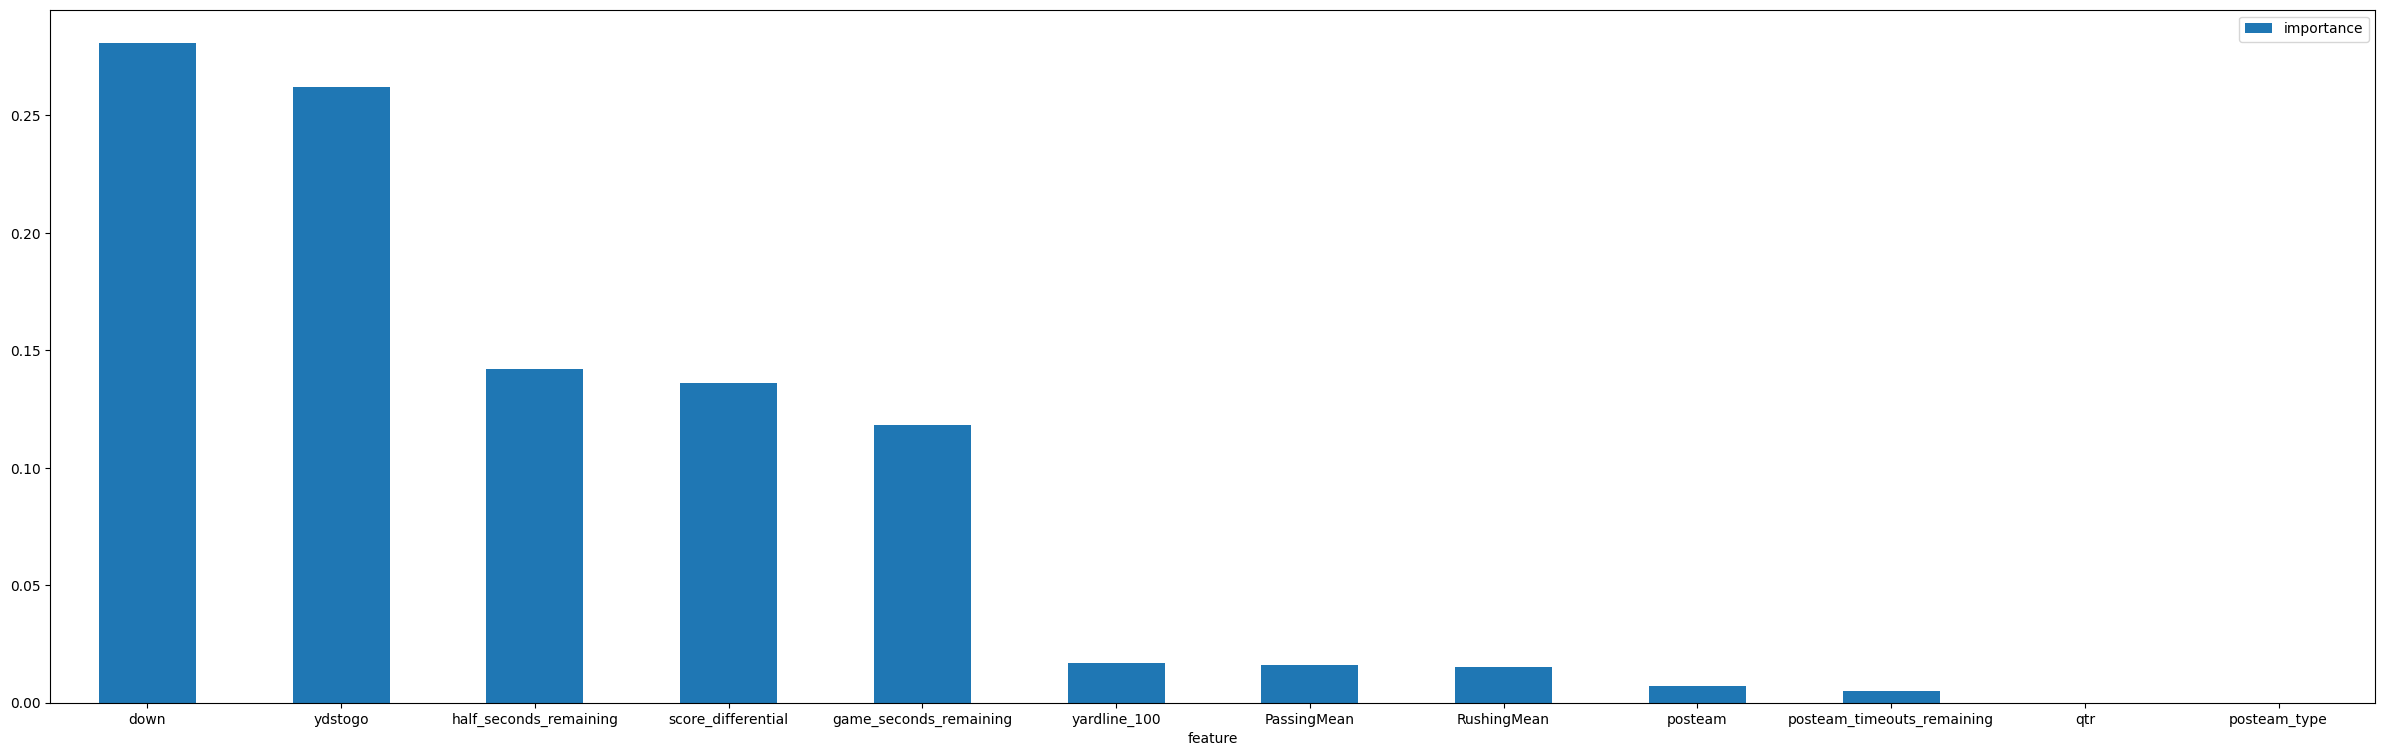

In [34]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(gbc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(30,9),rot=0)

Salvando as funcoes criadas com o pickle para integrar com o site

In [35]:
data = {"model": gbc, "le_posteam": le_posteam, "le_posteam_type": le_posteam_type}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [36]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

gbc = data["model"]
le_posteam = data["le_posteam"]
le_posteam_type = data["le_posteam_type"]

In [37]:
y_test = gbc.predict(X)
y_test

array(['pass'], dtype=object)